<h2 style="font-size:3rem;color:black;"> Problem Statement</h2>

<h2 style="font-size:2rem;color:black;"> predicting whether a loan was good or bad</h2>


<h2 style="font-size:1.5rem;color:black;"> Importing Libraries</h2>

In [286]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

from datetime import datetime
from datetime import date


pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_theme(style = "darkgrid")
import warnings
warnings.filterwarnings('ignore')

<h2 style="font-size:1.5rem;color:black;"> Loading the datasets</h2>

In [326]:
#train dataset
trainperf = pd.read_csv("trainperf.csv")
trainprevloans = pd.read_csv("trainprevloans.csv")
traindemographics = pd.read_csv("traindemographics.csv")

#test dataset
testprevloans = pd.read_csv("testprevloans.csv")
testperf = pd.read_csv("testperf.csv")
testdemographics = pd.read_csv("testdemographics.csv")

<h2 style="font-size:2rem;color:black;"> 1.1 trainperf</h2>


<h2 style="font-size:1.5rem;color:black;"> - repeat loan that the customer has taken</h2>


In [327]:
print(str(trainperf.shape[0]) + " entries")
print(str(trainperf.shape[1]) + " Columns")
trainperf.head(3)

4368 entries
10 Columns


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good


In [4]:
trainperf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [40]:
print(trainperf.apply(lambda col: col.nunique()))

customerid               4368
systemloanid             4368
loannumber                 23
approveddate             4362
creationdate             4364
loanamount                 10
totaldue                   47
termdays                    4
referredby                521
good_bad_flag               2
approval_time_seconds      77
dailypremium               43
dtype: int64


[Text(0.5, 1.0, 'good_bad_flag')]

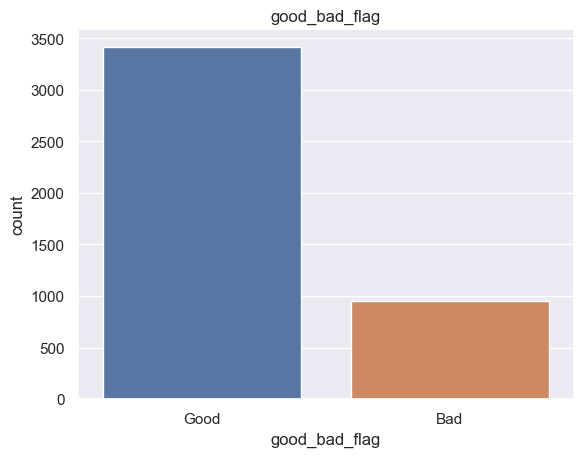

In [173]:
#value counts for good_bad flags

trainperf["good_bad_flag"].value_counts()
sns.countplot(data=trainperf, x="good_bad_flag").set(title="good_bad_flag")

In [174]:
#pasrsing datetime columns
trainperf['approveddate'] = pd.to_datetime(trainperf['approveddate'])
trainperf['creationdate'] = pd.to_datetime(trainperf['creationdate'])

In [175]:
# getting approval time

trainperf['approval_time_seconds'] = (trainperf['approveddate'] - trainperf['creationdate']).dt.seconds

In [176]:
# calculating daily premium

trainperf["dailypremium"] = round(trainperf['totaldue']/trainperf['termdays'])

In [177]:
trainperf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,approval_time_seconds,dailypremium
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,Good,3609,1150.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,Good,3623,575.0
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,Good,3606,1483.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,Good,3606,767.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,Good,3606,1467.0


[Text(0.5, 1.0, 'daily premium in relation to loan taken')]

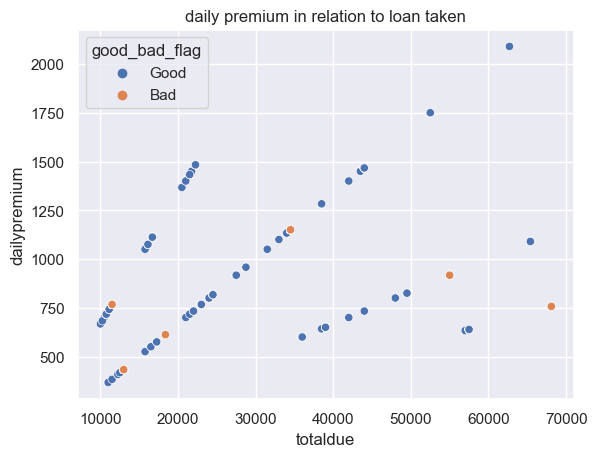

In [178]:
# relationship between daily payment and total amount
sns.scatterplot(data=trainperf, x="totaldue", y="dailypremium", hue="good_bad_flag").set(title="daily premium in relation to loan taken")


<AxesSubplot:xlabel='loannumber', ylabel='approval_time_seconds'>

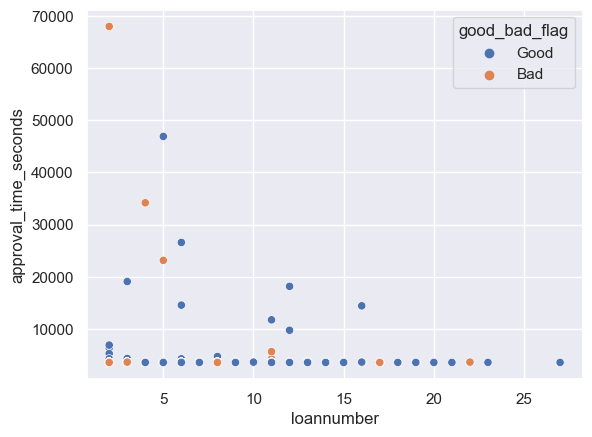

In [179]:
#loan number vs approval time

sns.scatterplot(data=trainperf, x="loannumber", y="approval_time_seconds", hue="good_bad_flag")

<AxesSubplot:>

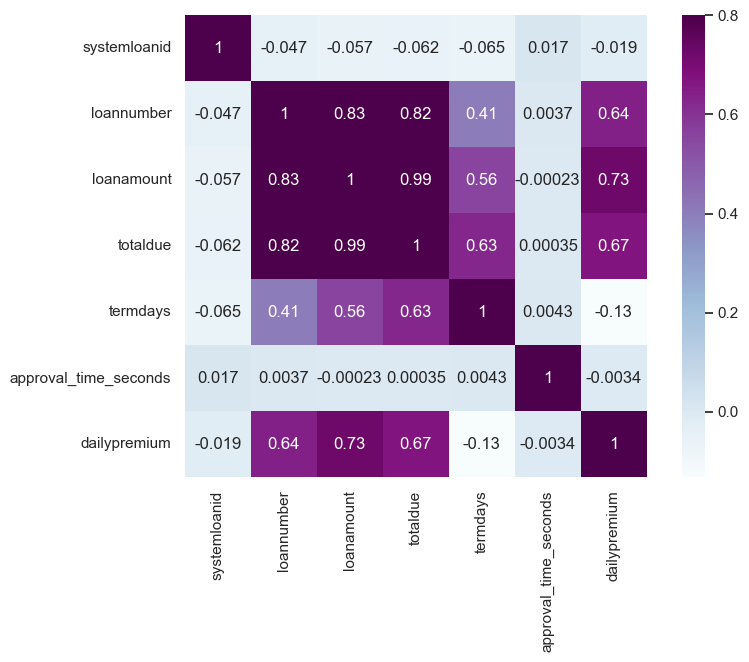

In [180]:
matrix = trainperf.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix,vmax=.8,square=True,cmap='BuPu', annot = True)

In [204]:
# selecting relevant features
trainperf_filtered = trainperf.drop(labels = ["approveddate","creationdate","referredby"], axis=1)
trainperf_filtered.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,approval_time_seconds,dailypremium
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,3609,1150.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,15000.0,17250.0,30,Good,3623,575.0
2,8a8588f35438fe12015444567666018e,301966580,7,20000.0,22250.0,15,Good,3606,1483.0
3,8a85890754145ace015429211b513e16,301999343,3,10000.0,11500.0,15,Good,3606,767.0
4,8a858970548359cc0154883481981866,301962360,9,40000.0,44000.0,30,Good,3606,1467.0


<h2 style="font-size:2.5rem;color:black;">Remarks</h2>

The Following was done:
 - Creation of Approval time taken column "approvaltime"
 - Creation of dailypremium "amount a customer is suppossed to pay daily inorder to clear the loan on time"
 
It's inferred that most customer cleared their loans on time 

approval time was less to cutomers who had taken loans previously

Dropped irrelevant features

<h2 style="font-size:2rem;color:black;"> 1.2 trainprevloans</h2>


<h2 style="font-size:1.5rem;color:black;"> - This dataset contains all previous loans that the customer had prior </h2>

In [14]:
print(str(trainprevloans.shape[0]) + " entries")
print(str(trainprevloans.shape[1]) + " columns")
trainprevloans.head()

18183 entries
12 columns


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [52]:
trainprevloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customerid       18183 non-null  object        
 1   systemloanid     18183 non-null  int64         
 2   loannumber       18183 non-null  int64         
 3   approveddate     18183 non-null  datetime64[ns]
 4   creationdate     18183 non-null  datetime64[ns]
 5   loanamount       18183 non-null  float64       
 6   totaldue         18183 non-null  float64       
 7   termdays         18183 non-null  int64         
 8   closeddate       18183 non-null  datetime64[ns]
 9   referredby       1026 non-null   object        
 10  firstduedate     18183 non-null  datetime64[ns]
 11  firstrepaiddate  18183 non-null  datetime64[ns]
 12  paytime          18183 non-null  float64       
dtypes: datetime64[ns](5), float64(3), int64(3), object(2)
memory usage: 1.8+ MB


In [16]:
trainprevloans.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [70]:
print(trainprevloans.apply(lambda col : col.unique()))

customerid         [8a2a81a74ce8c05d014cfb32a0da1049, 8a8588f3543...
systemloanid       [301682320, 301883808, 301831714, 301861541, 3...
loannumber         [2, 9, 8, 5, 6, 3, 7, 1, 4, 10, 11, 12, 13, 15...
approveddate       [2016-08-15T18:22:40.000000000, 2017-04-28T18:...
creationdate       [2016-08-15T17:22:32.000000000, 2017-04-28T17:...
loanamount         [10000.0, 20000.0, 30000.0, 40000.0, 25000.0, ...
totaldue           [13000.0, 23800.0, 11500.0, 39000.0, 24500.0, ...
termdays                                            [30, 15, 60, 90]
closeddate         [2016-09-01T16:06:48.000000000, 2017-05-28T14:...
referredby         [nan, 8a858e6c5c88d145015c89430ef61a5d, 8a858f...
firstduedate       [2016-09-14T00:00:00.000000000, 2017-05-30T00:...
firstrepaiddate    [2016-09-01T15:51:43.000000000, 2017-05-26T00:...
paytime            [17.0, 27.0, 52.0, 14.0, 29.0, 30.0, 32.0, 26....
paytime_days       [17.0, 27.0, 52.0, 14.0, 29.0, 30.0, 32.0, 26....
dtype: object


In [45]:
print(trainprevloans.apply(lambda col : col.nunique()))

customerid          4359
systemloanid       18183
loannumber            26
approveddate       18172
creationdate       18173
loanamount            16
totaldue              97
termdays               4
closeddate         17955
referredby           521
firstduedate         363
firstrepaiddate    18011
paytime            15731
dtype: int64


In [182]:
#parsing the datetime

trainprevloans[
    ['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate']] = trainprevloans[
    ['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate']].apply(pd.to_datetime)


In [183]:
# getting days taken to pay

trainprevloans['paytime_days'] =round(((trainprevloans['firstrepaiddate'] - trainprevloans['approveddate'])/ pd.Timedelta(hours=1))/24)

In [185]:
trainprevloans.head(3)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,paytime_days
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,17.0
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,27.0
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,52.0


In [67]:
trainprevloans.paytime_days.min()

0.0

In [69]:
trainprevloans.paytime_days.describe()

count    18183.000000
mean        23.070945
std         12.109242
min          0.000000
25%         14.000000
50%         25.000000
75%         30.000000
max        381.000000
Name: paytime_days, dtype: float64

<AxesSubplot:xlabel='customerid', ylabel='paytime_days'>

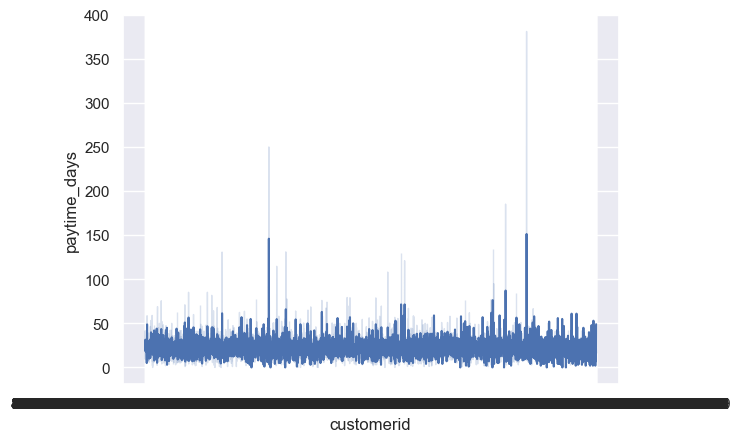

In [68]:
#sns.lineplot(data=trainprevloans, x = "customerid", y = "paytime_days" )

In [186]:
conditions = [trainprevloans["paytime_days"] > trainprevloans["termdays"],trainprevloans["paytime_days"] <= trainprevloans["termdays"]]
values = ["overdue", "ontime"]

trainprevloans["payed_ontime_late"] = np.select(conditions,values)

In [187]:
trainprevloans["payed_ontime_late"].value_counts()

ontime     14040
overdue     4143
Name: payed_ontime_late, dtype: int64

In [188]:
trainprevloans.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,paytime_days,payed_ontime_late
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,17.0,ontime
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,27.0,ontime
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,52.0,overdue
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43,14.0,ontime
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35,27.0,overdue


<AxesSubplot:xlabel='payed_ontime_late', ylabel='count'>

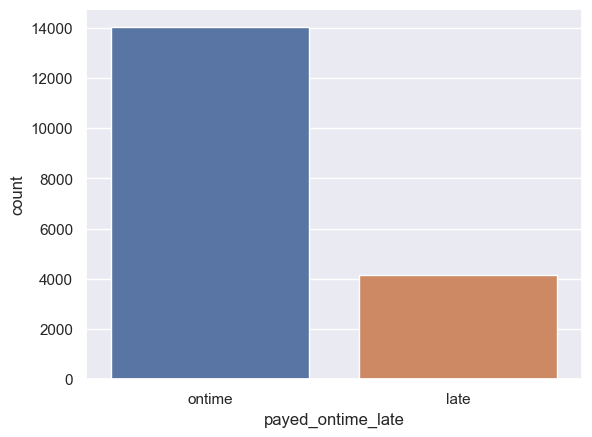

In [98]:
sns.countplot(data=trainprevloans, x="payed_ontime_late")

In [318]:
#dropping unnecessary columns
trainprevloans_filtered = trainprevloans.drop(labels = ["approveddate", "creationdate", "closeddate", "referredby", "firstrepaiddate","firstduedate"], axis=1)

trainprevloans_filtered.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,termdays_td,finalduedate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,10000.0,13000.0,30,30 days,2016-09-14 18:22:40
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,10000.0,13000.0,30,30 days,2017-05-28 18:39:07
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,20000.0,23800.0,30,30 days,2017-04-04 10:56:25
3,8a8588f35438fe12015444567666018e,301861541,5,10000.0,11500.0,15,15 days,2017-04-24 18:25:55
4,8a85890754145ace015429211b513e16,301941754,2,10000.0,11500.0,15,15 days,2017-07-02 09:29:57


<h2 style="font-size:2.5rem;color:black;">Remarks</h2>

New features
 - paytime_days
 - payed_ontime_late [some customers paid their before due dates while others paid after due dates]
 
It's inferred that most customer cleared their loans on time 

Dropped irrelevant features

<h2 style="font-size:2rem;color:black;"> 1.3 traindemographics</h2>


<h2 style="font-size:1.5rem;color:black;"> - demographics dataset </h2>

In [190]:
print(traindemographics.shape)
traindemographics.head()

(4346, 9)


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [22]:
traindemographics.isna().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
dtype: int64

In [299]:
#value_count for the banks

print(str(traindemographics['bank_name_clients'].nunique()) + ' Banks')
traindemographics['bank_name_clients'].value_counts()

18 Banks


GT Bank               1598
First Bank             590
Access Bank            432
UBA                    353
Zenith Bank            301
Diamond Bank           282
EcoBank                150
Stanbic IBTC           145
FCMB                   121
Fidelity Bank          103
Skye Bank              102
Sterling Bank           55
Wema Bank               28
Union Bank              23
Heritage Bank           22
Keystone Bank           19
Standard Chartered      15
Unity Bank               7
Name: bank_name_clients, dtype: int64

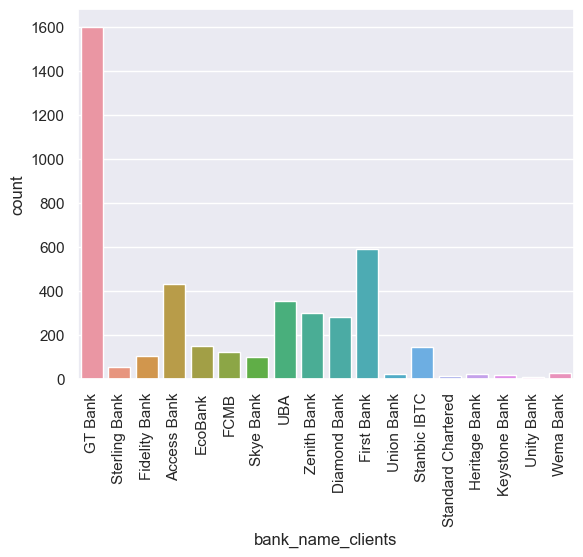

In [24]:
sns.countplot(data=traindemographics, x="bank_name_clients")
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='bank_account_type', ylabel='count'>

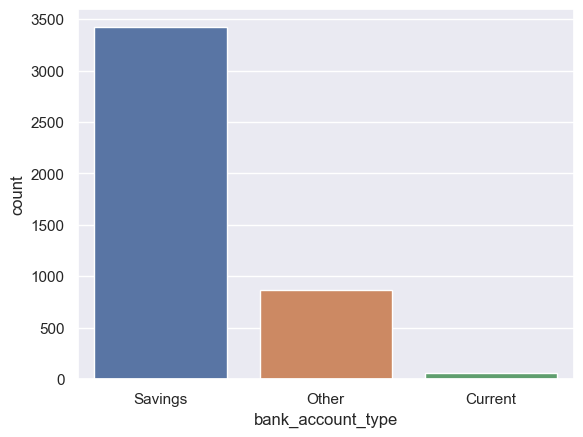

In [25]:
sns.countplot(data=traindemographics, x="bank_account_type")

In [26]:
traindemographics.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN


In [114]:
traindemographics.dtypes

customerid                            object
birthdate                     datetime64[ns]
bank_account_type                   category
longitude_gps                        float64
latitude_gps                         float64
bank_name_clients                   category
bank_branch_clients                 category
employment_status_clients           category
level_of_education_clients          category
dtype: object

In [104]:
#parsing datetime

traindemographics['birthdate'] = pd.to_datetime(traindemographics['birthdate'], errors='coerce')

In [115]:
# changing the dtypes "object" to "category"

traindemographics[["bank_account_type","bank_name_clients","bank_branch_clients",
                   "employment_status_clients","level_of_education_clients"]] = traindemographics[["bank_account_type",
                                                                                                   "bank_name_clients",
                                                                                                   "bank_branch_clients",
                                                                                                   "employment_status_clients",
                                                                                                   "level_of_education_clients"]].astype('category')


In [316]:
# unique for object columns
print(traindemographics.shape[0])
traindemographics.select_dtypes(include='object').nunique()

4346


customerid                    4334
birthdate                     3297
bank_account_type                3
bank_name_clients               18
bank_branch_clients             45
employment_status_clients        6
level_of_education_clients       4
dtype: int64

In [31]:
print(traindemographics.apply(lambda col: col.unique()))

customerid                    [8a858e135cb22031015cbafc76964ebd, 8a858e275c7...
birthdate                     [1973-10-10T00:00:00.000000000, 1986-01-21T00:...
bank_account_type             ['Savings', 'Other', 'Current']
Categories (3,...
longitude_gps                 [3.319219, 3.3255983, 5.7460998, 3.3628497, 8....
latitude_gps                  [6.5286039, 7.1194033, 5.5631737, 6.6424853, 1...
bank_name_clients             ['GT Bank', 'Sterling Bank', 'Fidelity Bank', ...
bank_branch_clients           [NaN, 'LAGOS', 'LADIPO', 'AWOLOWO', 'OGBA', .....
employment_status_clients     [NaN, 'Permanent', 'Student', 'Self-Employed',...
level_of_education_clients    [NaN, 'Secondary', 'Graduate', 'Post-Graduate'...
dtype: object


In [32]:
traindemographics.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

In [33]:
categorical_columns = ['bank_account_type','bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients']
for i in categorical_columns:
    print(traindemographics[i].unique())

['Savings', 'Other', 'Current']
Categories (3, object): ['Current', 'Other', 'Savings']
['GT Bank', 'Sterling Bank', 'Fidelity Bank', 'Access Bank', 'EcoBank', ..., 'Standard Chartered', 'Heritage Bank', 'Keystone Bank', 'Unity Bank', 'Wema Bank']
Length: 18
Categories (18, object): ['Access Bank', 'Diamond Bank', 'EcoBank', 'FCMB', ..., 'Union Bank', 'Unity Bank', 'Wema Bank', 'Zenith Bank']
[NaN, 'LAGOS', 'LADIPO', 'AWOLOWO', 'OGBA', ..., 'MAFOLUKU', 'AKURE BRANCH', '17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, L..., ' IDI - ORO MUSHIN', 'TINCAN']
Length: 46
Categories (45, object): [' IDI - ORO MUSHIN', '17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, L..., '40,SAPELE ROAD ,OPPOSITE DUMAZ JUNCTION BENIN..., '47 LAGOS ROAD, IKORODU', ..., 'STERLING BANK PLC 102, IJU ROAD, IFAKO BRANCH', 'TINCAN', 'TRANS AMADI', 'WHARF ROAD, APAPA']
[NaN, 'Permanent', 'Student', 'Self-Employed', 'Unemployed', 'Retired', 'Contract']
Categories (6, object): ['Contract', 'Permanent', 'Retired', 'Self-Employed

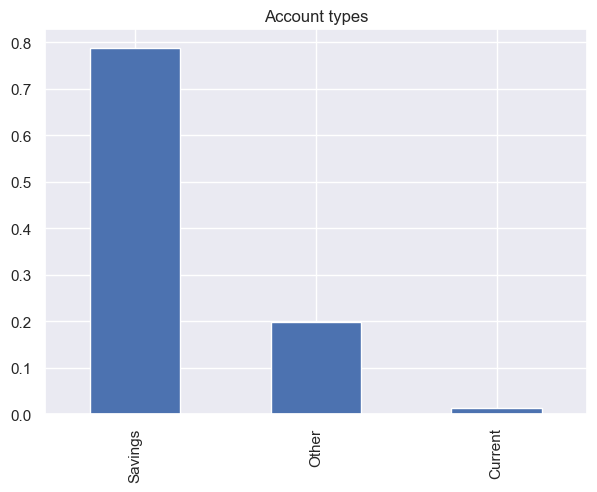

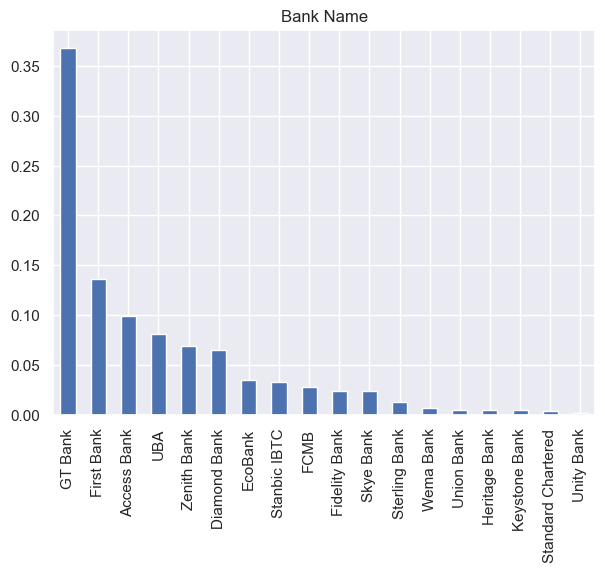

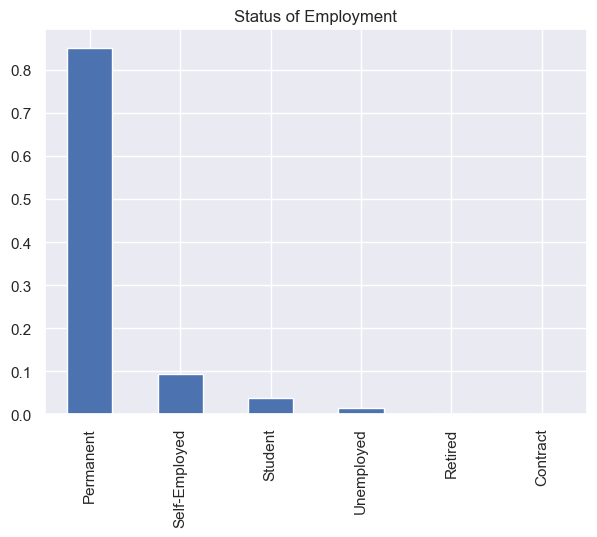

<AxesSubplot:title={'center':'Education Level'}>

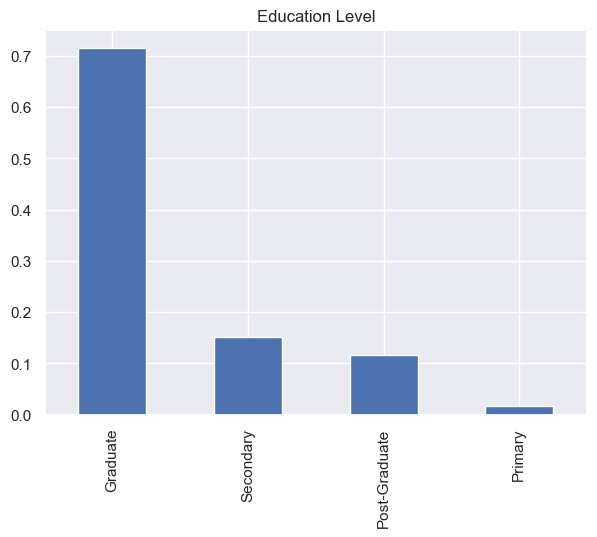

In [34]:
#understanding categorical columns

traindemographics["bank_account_type"].value_counts(normalize=True).plot.bar(figsize=(7,5), title="Account types")
plt.show()
traindemographics["bank_name_clients"].value_counts(normalize=True).plot.bar(figsize=(7,5), title="Bank Name")
plt.show()
traindemographics["employment_status_clients"].value_counts(normalize=True).plot.bar(figsize=(7,5), title="Status of Employment")
plt.show()
traindemographics["level_of_education_clients"].value_counts(normalize=True).plot.bar(figsize=(7,5), title=("Education Level"))

In [35]:
#Extract age of the customers from the birthdate

traindemographics['age'] =  date.today().year - pd.DatetimeIndex(traindemographics['birthdate']).year

In [36]:
traindemographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,50
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,37
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,36
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,32
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,41


<AxesSubplot:>

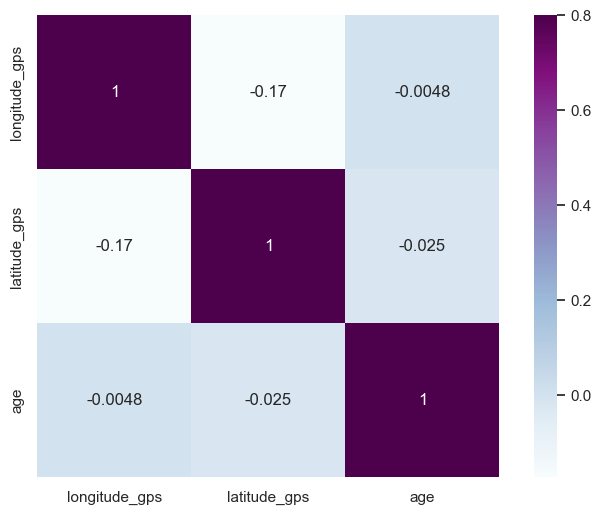

In [37]:
matrix = traindemographics.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix,vmax=.8,square=True,cmap='BuPu', annot = True)

In [206]:
#dropping unnecessary columns

traindemographics_filtered = traindemographics.drop("birthdate",  axis=1)
traindemographics_filtered.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


<h2 style="font-size:1.5rem;color:black;"> Merging the dataset </h2>

In [265]:
df = pd.merge(traindemographics_filtered,trainperf_filtered, on=["customerid"])

In [266]:
print(df.shape)
df.head()

(3277, 16)


,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,approval_time_seconds,dailypremium
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,301964962,2,10000.0,13000.0,30,Good,3606,433.0
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,301972172,2,10000.0,13000.0,30,Bad,3606,433.0
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,301976271,4,10000.0,13000.0,30,Good,3608,433.0
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,301997763,2,10000.0,11500.0,15,Good,3608,767.0
4,8a858ea05a859123015a8892914d15b7,Savings,3.365935,6.564823,Access Bank,NaN,Permanent,NaN,301992494,6,20000.0,24500.0,30,Good,3607,817.0


In [267]:
df = pd.merge(df,trainprevloans_filtered, on = "customerid", how="inner")

In [245]:
print(df.shape)
df.head()

(13693, 21)


,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid_x,loannumber_x,loanamount_x,totaldue_x,termdays_x,good_bad_flag,approval_time_seconds,dailypremium,systemloanid_y,loannumber_y,loanamount_y,totaldue_y,termdays_y
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,301964962,2,10000.0,13000.0,30,Good,3606,433.0,301943951,1,10000.0,11500.0,15
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,301972172,2,10000.0,13000.0,30,Bad,3606,433.0,301929966,1,10000.0,13000.0,30
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,301976271,4,10000.0,13000.0,30,Good,3608,433.0,301931228,3,10000.0,13000.0,30
3,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,301976271,4,10000.0,13000.0,30,Good,3608,433.0,301895253,1,10000.0,11500.0,15
4,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,301976271,4,10000.0,13000.0,30,Good,3608,433.0,301919784,2,10000.0,11500.0,15


In [133]:
df.describe()

,longitude_gps,latitude_gps,systemloanid_x,loannumber_x,loanamount_x,totaldue_x,termdays_x,approval_time_seconds,dailypremium,systemloanid_y,loannumber_y,loanamount_y,totaldue_y,termdays_y,paytime,paytime_days
count,13693.000000,13693.000000,1.369300e+04,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,1.369300e+04,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000
mean,4.482207,7.291442,3.019801e+08,8.401081,25688.673045,29812.666494,33.233769,3687.150880,932.714234,3.018395e+08,4.200760,16566.347769,19646.612269,26.742131,23.127145,23.127145
std,8.639590,3.436232,1.343531e+04,4.318780,12625.374212,13772.770273,14.440482,1124.817829,371.834521,9.304690e+04,3.269552,9375.687619,10512.238823,10.997624,12.144770,12.144770
min,-118.247009,-33.868818,3.019585e+08,2.000000,10000.000000,10000.000000,15.000000,3604.000000,367.000000,3.016001e+08,1.000000,3000.000000,3900.000000,15.000000,0.000000,0.000000
25%,3.354793,6.471885,3.019678e+08,5.000000,10000.000000,13000.000000,30.000000,3606.000000,650.000000,3.017767e+08,2.000000,10000.000000,11500.000000,15.000000,14.000000,14.000000
50%,3.576022,6.617633,3.019787e+08,8.000000,30000.000000,33000.000000,30.000000,3607.000000,817.000000,3.018545e+08,3.000000,10000.000000,13000.000000,30.000000,25.000000,25.000000
75%,6.364658,7.421333,3.019929e+08,11.000000,40000.000000,44000.000000,30.000000,3614.000000,1150.000000,3.019193e+08,6.000000,20000.000000,24500.000000,30.000000,30.000000,30.000000
max,151.209290,71.228069,3.020040e+08,27.000000,60000.000000,68100.000000,90.000000,67952.000000,2090.000000,3.020003e+08,26.000000,60000.000000,68100.000000,90.000000,381.000000,381.000000


In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13693 entries, 0 to 13692
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  13693 non-null  object 
 1   bank_account_type           13693 non-null  object 
 2   longitude_gps               13693 non-null  float64
 3   latitude_gps                13693 non-null  float64
 4   bank_name_clients           13693 non-null  object 
 5   bank_branch_clients         104 non-null    object 
 6   employment_status_clients   12330 non-null  object 
 7   level_of_education_clients  3464 non-null   object 
 8   systemloanid_x              13693 non-null  int64  
 9   loannumber_x                13693 non-null  int64  
 10  loanamount_x                13693 non-null  float64
 11  totaldue_x                  13693 non-null  float64
 12  termdays_x                  13693 non-null  int64  
 13  good_bad_flag               136

In [269]:
df.dtypes

customerid                     object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
systemloanid_x                  int64
loannumber_x                    int64
loanamount_x                  float64
totaldue_x                    float64
termdays_x                      int64
good_bad_flag                  object
approval_time_seconds           int64
dailypremium                  float64
systemloanid_y                  int64
loannumber_y                    int64
loanamount_y                  float64
totaldue_y                    float64
termdays_y                      int64
dtype: object

In [270]:
df.isna().sum()

customerid                        0
bank_account_type                 0
longitude_gps                     0
latitude_gps                      0
bank_name_clients                 0
bank_branch_clients           13589
employment_status_clients      1363
level_of_education_clients    10229
systemloanid_x                    0
loannumber_x                      0
loanamount_x                      0
totaldue_x                        0
termdays_x                        0
good_bad_flag                     0
approval_time_seconds             0
dailypremium                      0
systemloanid_y                    0
loannumber_y                      0
loanamount_y                      0
totaldue_y                        0
termdays_y                        0
dtype: int64

<h2 style="font-size:1.5rem;color:black;"> Imputation </h2>

In [271]:
# dealing with null values in "employment_status_clients" & "level_of_education_clients"

df["employment_status_clients"].fillna("hustling", inplace=True)
df["level_of_education_clients"].fillna("illiterate", inplace=True)

In [272]:
#transforming object columns to category columns

objects_columns = ["bank_account_type", "bank_name_clients", "bank_branch_clients",
                   "employment_status_clients","level_of_education_clients","good_bad_flag"]
for i in objects_columns:
    df[i] = df[i].astype('category')

In [217]:
df.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid_x,loannumber_x,loanamount_x,totaldue_x,termdays_x,good_bad_flag,approval_time_seconds,dailypremium,systemloanid_y,loannumber_y,loanamount_y,totaldue_y,termdays_y
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,hustling,illiterate,301964962,2,10000.0,13000.0,30,Good,3606,433.0,301943951,1,10000.0,11500.0,15
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,illiterate,301972172,2,10000.0,13000.0,30,Bad,3606,433.0,301929966,1,10000.0,13000.0,30
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,hustling,illiterate,301976271,4,10000.0,13000.0,30,Good,3608,433.0,301931228,3,10000.0,13000.0,30
3,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,hustling,illiterate,301976271,4,10000.0,13000.0,30,Good,3608,433.0,301895253,1,10000.0,11500.0,15
4,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,hustling,illiterate,301976271,4,10000.0,13000.0,30,Good,3608,433.0,301919784,2,10000.0,11500.0,15


In [218]:
df.columns

Index(['customerid', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'bank_branch_clients', 'employment_status_clients',
       'level_of_education_clients', 'systemloanid_x', 'loannumber_x',
       'loanamount_x', 'totaldue_x', 'termdays_x', 'good_bad_flag',
       'approval_time_seconds', 'dailypremium', 'systemloanid_y',
       'loannumber_y', 'loanamount_y', 'totaldue_y', 'termdays_y'],
      dtype='object')

In [273]:
df_columns = ['bank_account_type','bank_name_clients','employment_status_clients','level_of_education_clients','good_bad_flag']
for item in df_columns:
    print(df[item].unique())

['Savings', 'Other', 'Current']
Categories (3, object): ['Current', 'Other', 'Savings']
['GT Bank', 'Sterling Bank', 'Fidelity Bank', 'Access Bank', 'EcoBank', ..., 'Standard Chartered', 'Heritage Bank', 'Keystone Bank', 'Unity Bank', 'Wema Bank']
Length: 18
Categories (18, object): ['Access Bank', 'Diamond Bank', 'EcoBank', 'FCMB', ..., 'Union Bank', 'Unity Bank', 'Wema Bank', 'Zenith Bank']
['hustling', 'Permanent', 'Student', 'Self-Employed', 'Unemployed', 'Retired', 'Contract']
Categories (7, object): ['Contract', 'Permanent', 'Retired', 'Self-Employed', 'Student', 'Unemployed', 'hustling']
['illiterate', 'Secondary', 'Graduate', 'Post-Graduate', 'Primary']
Categories (5, object): ['Graduate', 'Post-Graduate', 'Primary', 'Secondary', 'illiterate']
['Good', 'Bad']
Categories (2, object): ['Bad', 'Good']


<h2 style="font-size:1.5rem;color:black;"> Encoding </h2>
<h2 style="font-size:1.2rem;color:black;"> Label Encoding </h2>

In [274]:
labelencoder = LabelEncoder()
df['good_bad_flag'] = labelencoder.fit_transform(df['good_bad_flag'])

In [317]:
categorical_columns = ['bank_account_type','bank_name_clients','employment_status_clients','level_of_education_clients']

count_encoder = ce.CountEncoder()
count_encoded = count_encoder.fit_transform(df[categorical_columns])
df = df.join(count_encoded.add_suffix("_count"))
df.drop(labels=['bank_account_type','bank_name_clients','employment_status_clients','level_of_education_clients'], axis=1)

KeyError: "None of [Index(['bank_account_type', 'bank_name_clients', 'employment_status_clients',\n       'level_of_education_clients'],\n      dtype='object')] are in the [columns]"

In [264]:
df.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid_x,loannumber_x,loanamount_x,totaldue_x,termdays_x,good_bad_flag,approval_time_seconds,dailypremium,systemloanid_y,loannumber_y,loanamount_y,totaldue_y,termdays_y,bank_account_type_count,bank_name_clients_count,employment_status_clients_count,level_of_education_clients_count
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,hustling,illiterate,301964962,2,10000.0,13000.0,30,1,3606,433.0,301943951,1,10000.0,11500.0,15,8311,5034,1363,10229
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,illiterate,301972172,2,10000.0,13000.0,30,0,3606,433.0,301929966,1,10000.0,13000.0,30,8311,112,9138,10229
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,hustling,illiterate,301976271,4,10000.0,13000.0,30,1,3608,433.0,301931228,3,10000.0,13000.0,30,8311,267,1363,10229
3,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,hustling,illiterate,301976271,4,10000.0,13000.0,30,1,3608,433.0,301895253,1,10000.0,11500.0,15,8311,267,1363,10229
4,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,hustling,illiterate,301976271,4,10000.0,13000.0,30,1,3608,433.0,301919784,2,10000.0,11500.0,15,8311,267,1363,10229


In [263]:
df.describe()

,longitude_gps,latitude_gps,systemloanid_x,loannumber_x,loanamount_x,totaldue_x,termdays_x,good_bad_flag,approval_time_seconds,dailypremium,systemloanid_y,loannumber_y,loanamount_y,totaldue_y,termdays_y,bank_account_type_count,bank_name_clients_count,employment_status_clients_count,level_of_education_clients_count
count,13693.000000,13693.000000,1.369300e+04,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,1.369300e+04,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000,13693.000000
mean,4.482207,7.291442,3.019801e+08,8.401081,25688.673045,29812.666494,33.233769,0.815380,3687.150880,932.714234,3.018395e+08,4.200760,16566.347769,19646.612269,26.742131,7042.169064,2528.678668,6657.832542,8131.764478
std,8.639590,3.436232,1.343531e+04,4.318780,12625.374212,13772.770273,14.440482,0.388003,1124.817829,371.834521,9.304690e+04,3.269552,9375.687619,10512.238823,10.997624,1663.597939,1964.216987,3537.404459,3633.833802
min,-118.247009,-33.868818,3.019585e+08,2.000000,10000.000000,10000.000000,15.000000,0.000000,3604.000000,367.000000,3.016001e+08,1.000000,3000.000000,3900.000000,15.000000,154.000000,14.000000,10.000000,36.000000
25%,3.354793,6.471885,3.019678e+08,5.000000,10000.000000,13000.000000,30.000000,1.000000,3606.000000,650.000000,3.017767e+08,2.000000,10000.000000,11500.000000,15.000000,5228.000000,983.000000,2319.000000,2508.000000
50%,3.576022,6.617633,3.019787e+08,8.000000,30000.000000,33000.000000,30.000000,1.000000,3607.000000,817.000000,3.018545e+08,3.000000,10000.000000,13000.000000,30.000000,8311.000000,1932.000000,9138.000000,10229.000000
75%,6.364658,7.421333,3.019929e+08,11.000000,40000.000000,44000.000000,30.000000,1.000000,3614.000000,1150.000000,3.019193e+08,6.000000,20000.000000,24500.000000,30.000000,8311.000000,5034.000000,9138.000000,10229.000000
max,151.209290,71.228069,3.020040e+08,27.000000,60000.000000,68100.000000,90.000000,1.000000,67952.000000,2090.000000,3.020003e+08,26.000000,60000.000000,68100.000000,90.000000,8311.000000,5034.000000,9138.000000,10229.000000


<h2 style="font-size:2rem;color:black;"> Train_Test_Split </h2>

In [278]:
X = df.drop(labels = ["customerid","bank_branch_clients","systemloanid_x","systemloanid_y","good_bad_flag"], axis=1)
y = df["good_bad_flag"]

In [320]:
print(X.shape)
X.head()

(13693, 16)


,longitude_gps,latitude_gps,loannumber_x,loanamount_x,totaldue_x,termdays_x,approval_time_seconds,dailypremium,loannumber_y,loanamount_y,totaldue_y,termdays_y,bank_account_type_count,bank_name_clients_count,employment_status_clients_count,level_of_education_clients_count
0,3.319219,6.528604,2,10000.0,13000.0,30,3606,433.0,1,10000.0,11500.0,15,8311,5034,1363,10229
1,3.325598,7.119403,2,10000.0,13000.0,30,3606,433.0,1,10000.0,13000.0,30,8311,112,9138,10229
2,5.746100,5.563174,4,10000.0,13000.0,30,3608,433.0,3,10000.0,13000.0,30,8311,267,1363,10229
3,5.746100,5.563174,4,10000.0,13000.0,30,3608,433.0,1,10000.0,11500.0,15,8311,267,1363,10229
4,5.746100,5.563174,4,10000.0,13000.0,30,3608,433.0,2,10000.0,11500.0,15,8311,267,1363,10229


In [280]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: good_bad_flag, dtype: int32

In [283]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape 

((10954, 16), (2739, 16), (10954,), (2739,))

In [319]:
rf_clf = RandomForestClassifier(criterion='gini', bootstrap=True, random_state=100)
smote_sampler = SMOTE(random_state=9)
pipeline = Pipeline(steps = [['smote', smote_sampler],
                             ['classifier', rf_clf]])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


In [288]:
print(f"Recall: { round(recall_score(y_test, y_pred)*100, 2) }")
print(f"Precision: { round(precision_score(y_test, y_pred)*100, 2) }")
print(f"F1-Score: { round(f1_score(y_test, y_pred)*100, 4) }")
print(f"Accuracy score: { round(accuracy_score(y_test, y_pred)*100, 2) }")
print(f"AUC Score: { round(roc_auc_score(y_test, y_pred)*100, 2) }")

Recall: 96.42
Precision: 97.82
F1-Score: 97.1132
Accuracy score: 95.33
AUC Score: 93.47


In [321]:
X.columns

Index(['longitude_gps', 'latitude_gps', 'loannumber_x', 'loanamount_x',
       'totaldue_x', 'termdays_x', 'approval_time_seconds', 'dailypremium',
       'loannumber_y', 'loanamount_y', 'totaldue_y', 'termdays_y',
       'bank_account_type_count', 'bank_name_clients_count',
       'employment_status_clients_count', 'level_of_education_clients_count'],
      dtype='object')

In [ ]:
Index(['customerid', 'systemloanid_x', 'loannumber_x', 'loanamount_x',
       'totaldue_x', 'termdays_x', 'systemloanid_y', 'loannumber_y',
       'loanamount_y', 'totaldue_y', 'termdays_y', 'paytime_days',
       'payed_ontime_late', 'systemloanid', 'loannumber', 'loanamount',
       'totaldue', 'termdays'],
      dtype='object')

Notes:
plotting all columns 

featuers= ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

for f in featuers:
    sns.countplot(x=f , data=loan_data , hue= 'Loan_Status')
    plt.title(f)
    plt.show()
    
    
    
    
b)

 sample input from gender to Property_Area = 1,1,4,1,0,3036,2504.0,158.0,360.0,0.0,1
Input_data = (1,1,4,1,0,3036,2504.0,158.0,360.0,0.0,1)

Input_data_as_numpy_array = np.asarray(Input_data)

reshaping the data as we are pridicting for one instance

input_reshaping = Input_data_as_numpy_array.reshape(1,-1)

x = classifier.predict(input_reshaping)

print(x)


train[‘Loan_Status’].value_counts(normalize=True) 
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64
train[‘Loan_Status’].value_counts().plot.bar()